In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('../Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)

In [5]:
df.columns=['Sales']

In [14]:
df.index.freq='MS'

In [12]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


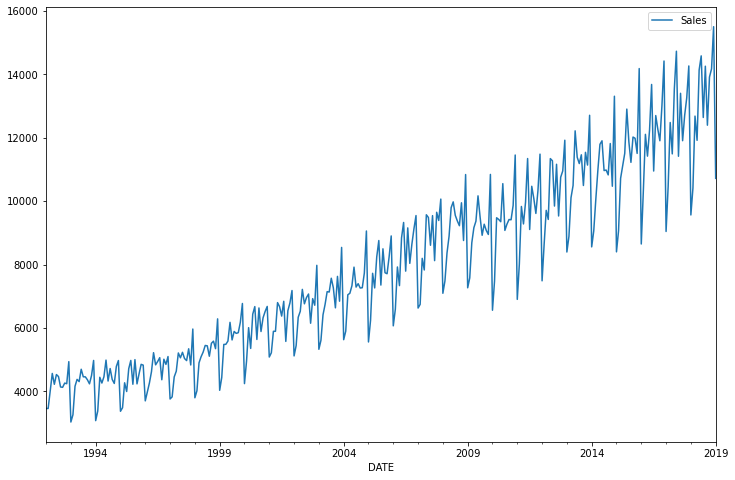

In [7]:
df.plot(figsize=(12,8));

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

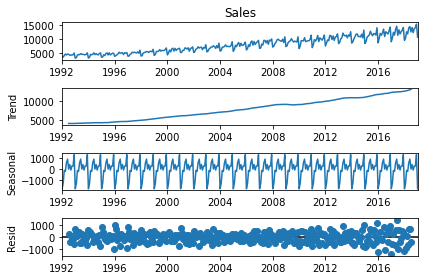

In [10]:
seasonal_decompose(df['Sales']).plot();

In [13]:
len(df)

325

### lets evaluate on last 12 months data

In [15]:
train=df.iloc[:313]
test=df.iloc[313:]

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
sc=MinMaxScaler()
sc.fit(train)
train_sc=sc.transform(train)
test_sc=sc.transform(test)

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [47]:
n_input=12
n_features=1
train_generator=TimeseriesGenerator(data=train_sc,
                             targets=train_sc,
                             length=n_input,
                             batch_size=1)

In [48]:
# len(train_sc)
# len(generator)
# x,y=generator[0]
# x.shape

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [51]:
model=Sequential()
model.add(LSTM(150,
          activation='relu',
          input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.fit_generator(train_generator,epochs=25)

Epoch 1/25
301/301 [==============================] - 5s 17ms/step - loss: 0.0185
Epoch 2/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0088
Epoch 3/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0085
Epoch 4/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0076
Epoch 5/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0056
Epoch 6/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0041
Epoch 7/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0034
Epoch 8/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0030A: 0s - loss: 0.00
Epoch 9/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0027
Epoch 10/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0024
Epoch 11/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0020
Epoch 12/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0019
Epoch 

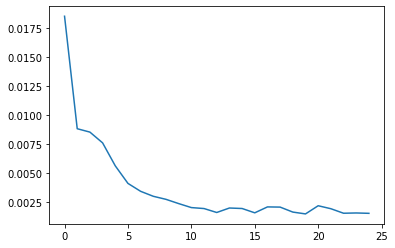

In [55]:
loss=model.history.history['loss']
plt.plot(range(len(loss)),loss);

In [76]:
first_eval_batch=train_sc[-12:].reshape(1,n_input,n_features)

In [78]:
model.predict(first_eval_batch)

array([[0.6546414]], dtype=float32)

# RNN forecast

In [82]:
test_predictions=[]


first_eval_batch=train_sc[-n_input:]
current_batch=first_eval_batch.reshape(1,n_input,n_features)

#forecasting till len(test).. you can put values according to u
for i in range(len(test)):
    current_pred=model.predict(current_batch)
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[current_pred],axis=1)
    

In [100]:
test_predictions=[item for s in test_predictions for item in s]

In [101]:
test_predictions

[array([0.6546414], dtype=float32),
 array([0.7840783], dtype=float32),
 array([0.7320285], dtype=float32),
 array([0.8897629], dtype=float32),
 array([0.9597309], dtype=float32),
 array([0.72238165], dtype=float32),
 array([0.8629673], dtype=float32),
 array([0.7468714], dtype=float32),
 array([0.8150678], dtype=float32),
 array([0.8597295], dtype=float32),
 array([0.9241203], dtype=float32),
 array([0.56538427], dtype=float32)]

In [102]:
true_predictions=sc.inverse_transform(test_predictions)

In [103]:
true_predictions

array([[10689.64961982],
       [12203.93203169],
       [11595.00123835],
       [13440.33591461],
       [14258.89207023],
       [11482.14293975],
       [13126.85458702],
       [11768.64864665],
       [12566.47851628],
       [13088.97575307],
       [13842.28347123],
       [ 9645.43056023]])

In [107]:
test['preds']=true_predictions

c:\users\rhitc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [108]:
test

,Sales,preds
DATE,,
2018-02-01,10415,10689.649620
2018-03-01,12683,12203.932032
2018-04-01,11919,11595.001238
2018-05-01,14138,13440.335915
2018-06-01,14583,14258.892070
2018-07-01,12640,11482.142940
2018-08-01,14257,13126.854587
2018-09-01,12396,11768.648647
2018-10-01,13914,12566.478516


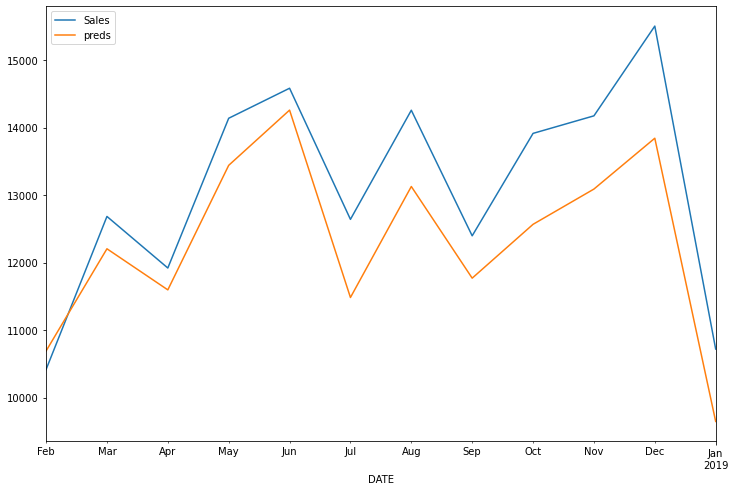

In [112]:
test.plot(legend=True,figsize=(12,8));

In [114]:
#model.save('name.h5')
#from keras.models import load_model
#new_model=laod_model('name.h5')